In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from scipy.signal import savgol_filter
import pickle
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
import os

import IPython
import IPython.display
import pydot

In [4]:
plt.style.use('ggplot')

# Read in Processed Data

## Filtering / Normalisation

In [5]:
def filter_data(input_data):
    output = input_data.copy()
    filtered = savgol_filter(output['GlucoseLevel'], 7, 3)
    output['GlucoseLevel'] = filtered
    return output

In [6]:
compartmentals = ['Short', 'Long', 'Carb']
col_names= ['GlucoseLevel', 'Long', 'Short', 'Carb']
time_ranges = ['15', '30', '60']

In [7]:
def normalise_data(training_data, testing_data):
    testing = testing_data.copy()
    training = training_data.copy()
    scaler = MinMaxScaler()
    scaler.fit(training)
    training[col_names] = scaler.fit_transform(training)
    testing[col_names] = scaler.transform(testing)
    return training, testing, scaler

In [8]:
datapath = '../../OhioT1DM/data/processed/'
train_563 = pd.read_csv(datapath + 'train_563.csv').set_index('ts')
train_588 = pd.read_csv(datapath + 'train_588.csv').set_index('ts')
train_570 = pd.read_csv(datapath + 'train_570.csv').set_index('ts')

test_563 = pd.read_csv(datapath + 'test_563.csv').set_index('ts')
test_588 = pd.read_csv(datapath + 'test_588.csv').set_index('ts')
test_570 = pd.read_csv(datapath + 'test_570.csv').set_index('ts')

In [9]:
all_train_data = [train_563, train_588, train_570]
all_test_data = [test_563, test_588, test_570]
all_filtered_data = [filter_data(x) for x in all_train_data]
patient_names = {0: '563', 1: '588', 2: '570'}
patient_indices = {'563' : 0, '588': 1, '570': 2}

In [10]:
def normalise_all_data(train_to_norm, test_to_norm):
    train_normed = []
    test_normed = []
    used_scalers = []
    for i in range(len(train_to_norm)):
        train = train_to_norm[i]
        test = test_to_norm[i]
        normed_tr, normed_te, scaler = normalise_data(train, test)
        train_normed.append(normed_tr)
        test_normed.append(normed_te)
        used_scalers.append(scaler)
    return train_normed, test_normed, used_scalers

        
all_train_normed, all_test_normed, scalers  = normalise_all_data(all_train_data, all_test_data)
all_train_filtnormed, all_test_filtnormed, filt_scalers = normalise_all_data(all_filtered_data, all_test_data)

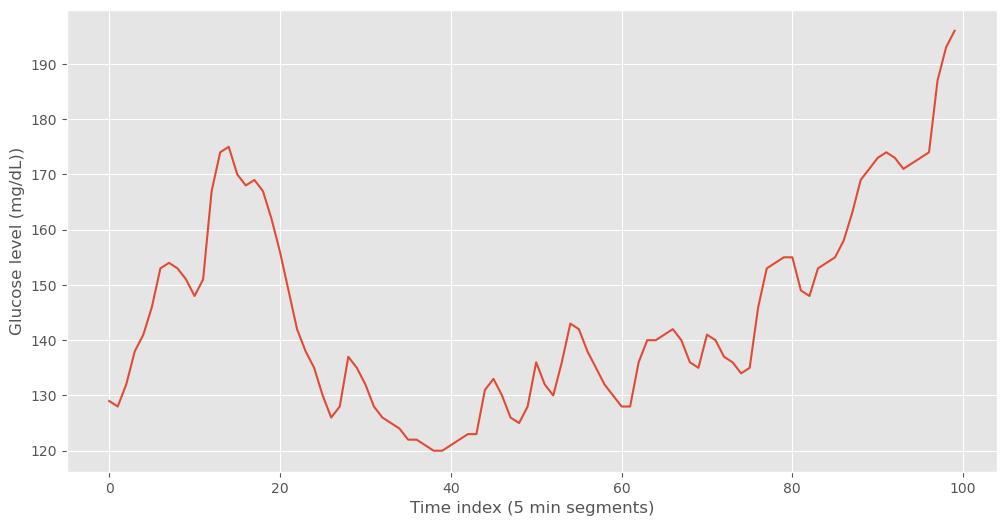

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel("Time index (5 min segments)")
plt.ylabel("Glucose level (mg/dL))")
plt.plot(list(range(100)), all_train_data[0]['GlucoseLevel'][100:200])

[]

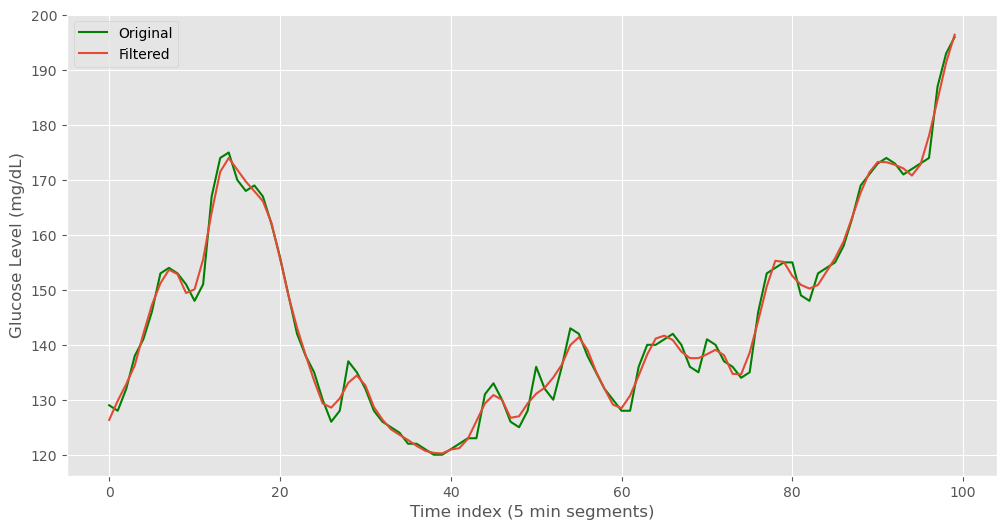

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(list(range(100)), all_train_data[0]['GlucoseLevel'][100:200], c='g', label='Original')
plt.plot(list(range(100)), all_filtered_data[0]['GlucoseLevel'][100:200], label='Filtered')
plt.xlabel("Time index (5 min segments)")
plt.ylabel("Glucose Level (mg/dL)")
plt.legend()
plt.plot()

[]

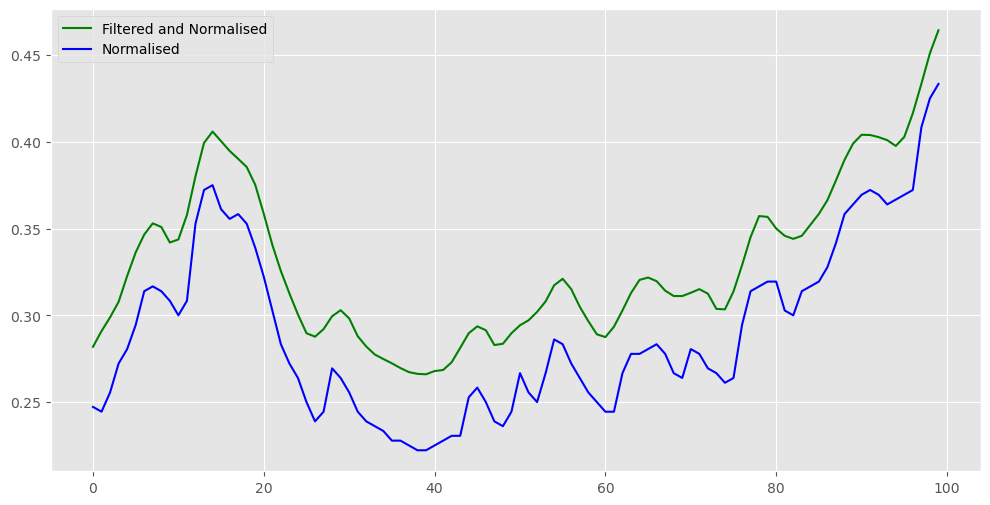

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(list(range(100)), all_train_filtnormed[0]['GlucoseLevel'][100:200], c='g', label='Filtered and Normalised')
plt.plot(list(range(100)), all_train_normed[0]['GlucoseLevel'][100:200], c='b', label='Normalised')
plt.legend()
plt.plot()

In [14]:
all_train_data[0].describe()

,GlucoseLevel,Long,Short,Carb
count,12124.00000,12124.000000,12124.000000,12124.000000
mean,146.07712,0.830823,12.535700,6.399876
std,49.68904,0.250614,9.056443,26.727100
min,40.00000,0.000000,0.000000,0.000000
25%,108.00000,0.700000,6.450000,0.000000
50%,140.00000,0.800000,11.035417,0.000000
75%,177.00000,0.800000,17.000434,1.700000
max,400.00000,1.600000,74.305208,378.750000


In [15]:
all_train_normed[0].describe()

,GlucoseLevel,Long,Short,Carb
count,12124.000000,12124.000000,12124.000000,12124.000000
mean,0.294659,0.519264,0.168706,0.016897
std,0.138025,0.156633,0.121882,0.070567
min,0.000000,0.000000,0.000000,0.000000
25%,0.188889,0.437500,0.086804,0.000000
50%,0.277778,0.500000,0.148515,0.000000
75%,0.380556,0.500000,0.228792,0.004488
max,1.000000,1.000000,1.000000,1.000000


# Setup Window Slicing Code

In [16]:
class PredictionRangeGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, test_df, label_columns=None, batch_size=32):
        
        self.batch_size = batch_size
        
        # Store data in Generator
        self.train_df = train_df
        self.test_df = test_df
        
        #Work out column indices for different labels
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name : i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:,:, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
        
            
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
            
        return inputs, labels
    
    def plot(self, model=None, plot_col='GlucoseLevel', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 2*max_subplots))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10, c='#00008B')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        label='Actual', c='#90EE90', edgecolors='k', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          label='Predicted',
                          marker='X', c='#808080', edgecolors='k', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time index (5 min segments)')
        
        
    def make_dataset(self, data, shuffle):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=self.batch_size,)
        
        ds = ds.map(self.split_window)
        
        return ds
        
    @property
    def train(self):
        return self.make_dataset(self.train_df, True)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df, False)
    
    @property
    def example(self):
        """Get and cache an example batch for plotting"""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch found, so get one from train df
            result = next(iter(self.train))
            self._example = result
        return result

# Setup a Baseline to Test Prediction Against

In [17]:
class LinearBaseline(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def call(self, inputs):
        """
        Simply returns last value as next value
        """
        return inputs[:, -1, tf.newaxis]

In [18]:
linear_base = LinearBaseline()
linear_base.compile(loss=tf.keras.losses.MeanSquaredError(),
                   metrics=[tf.keras.metrics.RootMeanSquaredError()],)

2023-04-18 10:59:02.739223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-18 10:59:02.739311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Dan): /proc/driver/nvidia/version does not exist
2023-04-18 10:59:02.740692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup Windows to be Predicted Over

In [19]:
PREV = 4

In [20]:
fifteen_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 3,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(all_train_data[2]['GlucoseLevel']),
    test_df=pd.DataFrame(all_test_data[2]['GlucoseLevel'])
)

thirty_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 6,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(all_train_data[2]['GlucoseLevel']),
    test_df=pd.DataFrame(all_test_data[2]['GlucoseLevel'])
)

sixty_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 12,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(all_train_data[2]['GlucoseLevel']),
    test_df=pd.DataFrame(all_test_data[2]['GlucoseLevel'])
)

def create_range(shift, train, test, prev=PREV):
    return PredictionRangeGenerator(
        input_width = PREV,
        label_width = 1,
        shift = shift,
        label_columns=['GlucoseLevel'],
        train_df=train,
        test_df=test
    )

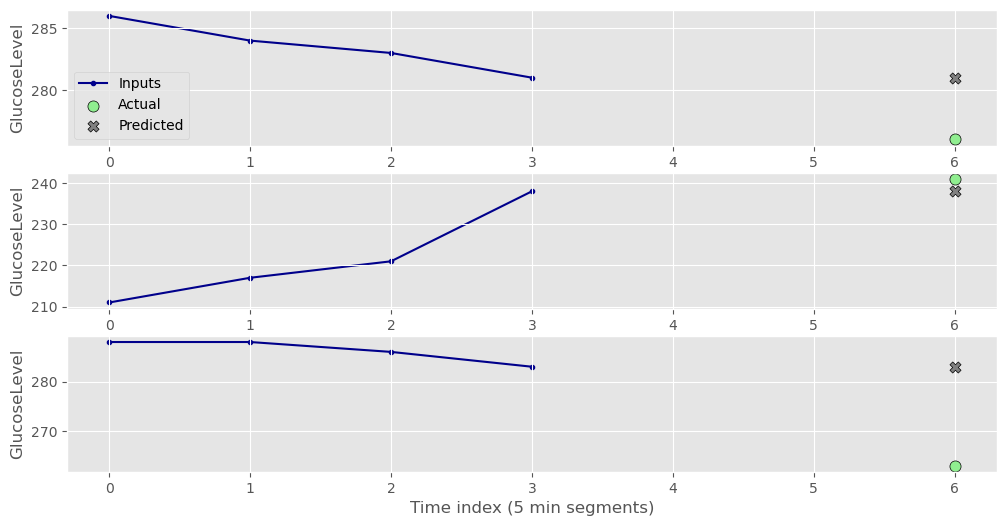

In [21]:
fifteen_range_g.plot(linear_base)

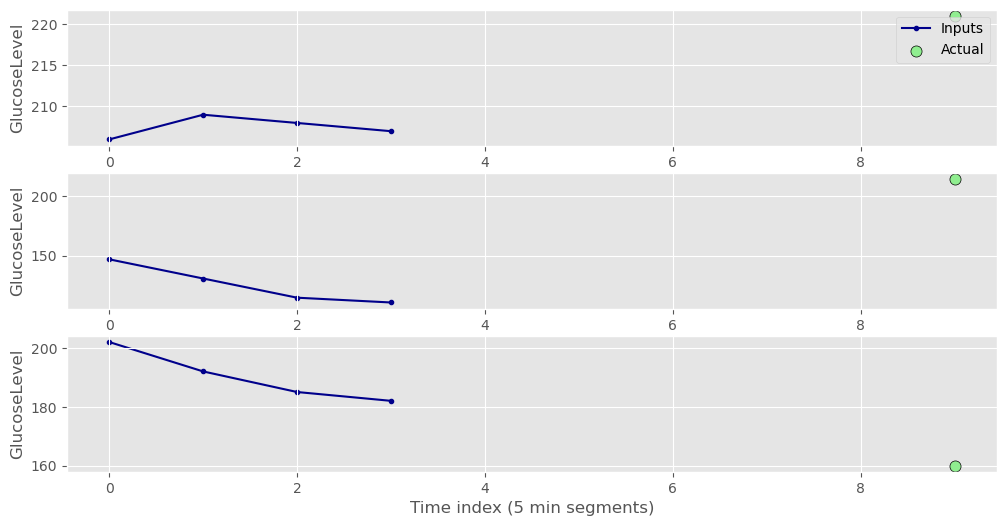

In [22]:
thirty_range_g.plot()

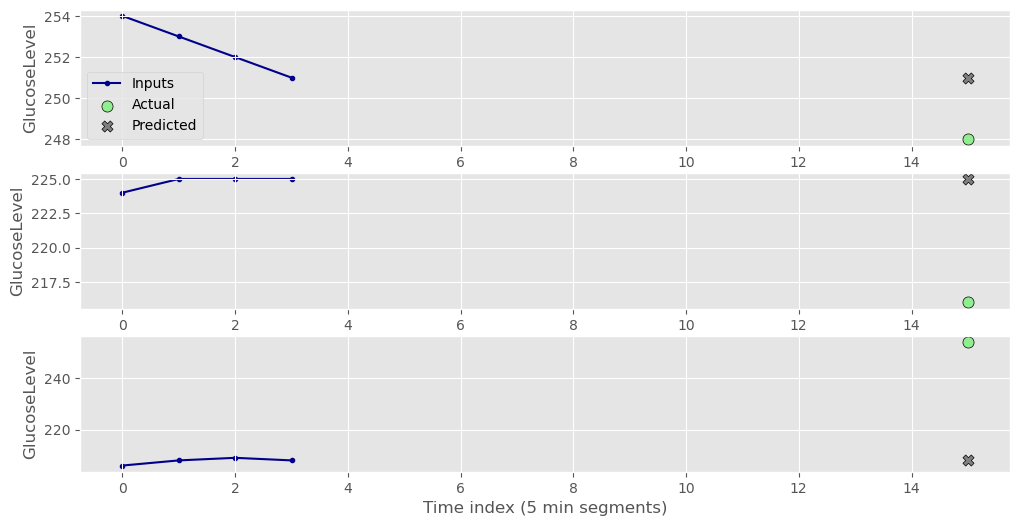

In [23]:
sixty_range_g.plot(linear_base)

# Setup Model Training Code

In [24]:
def get_scaled_glucose(scaler, val):
    scaled = (val - tf.constant(scaler.min_[0], dtype='float32')) / tf.constant(scaler.scale_[0], dtype='float32')
    return scaled

def inverse_glucose(scaler, glucose):
    temp = pd.DataFrame(np.zeros((len(glucose), len(col_names))), columns=col_names)
    temp['GlucoseLevel'] = glucose
    temp = pd.DataFrame(scaler.inverse_transform(temp), columns=col_names)
    return temp['GlucoseLevel'].values

In [25]:
class Normalised_MSE(tf.keras.losses.Loss):
    def __init__(self, scaler):
        super().__init__()
        self.scaler = scaler
    def call(self, y_true, y_pred):
        scaled_t = get_scaled_glucose(self.scaler, y_true)
        scaled_p = get_scaled_glucose(self.scaler, y_pred)
        val = tf.math.reduce_mean(tf.math.square(scaled_t - scaled_p))
        return val

def Normalised_RMSE(scaler):
    def RMSE(y_true, y_pred):
        scaled_t = get_scaled_glucose(scaler, y_true)
        scaled_p = get_scaled_glucose(scaler, y_pred)
        val = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(scaled_t - scaled_p)))
        return val
    return RMSE

In [26]:
# Setup function to train model on training data

def fit_model(model, predict_range, lr=0.01, MAX_EPOCHS=20):
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),
                        tf.keras.metrics.MeanAbsoluteError()])

    model_history = model.fit(predict_range.train, epochs=MAX_EPOCHS)
    return model_history

In [27]:
def fit_normalised_model(model, predict_range, scaler, lr=0.01, MAX_EPOCHS=20):
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[Normalised_RMSE(scaler)])

    model_history = model.fit(predict_range.train, epochs=MAX_EPOCHS)
    return model_history

In [28]:
def train_and_test_model(model, train, test, shift, previous=PREV, epochs=40):
    print("Running for Range: {} mins\n".format(shift*5))
    pred_range = create_range(shift, train, test, previous)
    fit_model(model, pred_range, lr=1e-3, MAX_EPOCHS=epochs)
    IPython.display.clear_output()
    train_acc = model.evaluate(pred_range.train)
    test_acc = model.evaluate(pred_range.test)
    print("Train Accuracy: {:.2f}, Test Accuracy: {:.2f}\n".format(train_acc[1], test_acc[1]))
    return train_acc[1], test_acc[1], model

def train_and_test_normed_model(model, train, test, shift, scaler, previous=PREV, epochs=40):
    print("Running for Range: {} mins\n".format(shift*5))
    pred_range = create_range(shift, train, test, previous)
    fit_normalised_model(model, pred_range, scaler, lr=1e-3, MAX_EPOCHS=epochs)
    IPython.display.clear_output()
    train_acc = model.evaluate(pred_range.train)
    test_acc = model.evaluate(pred_range.test)
    print("Train Accuracy: {:.2f}, Test Accuracy: {:.2f}\n".format(train_acc[1], test_acc[1]))
    return train_acc[1], test_acc[1], model

In [29]:
def save_result(result, path):
    f = open(path, "wb")
    pickle.dump(result, f)
    f.close()

def save_all_models(model_dict, prefix):
    for key in model_dict:
        for k, model in enumerate(model_dict[key]):
            save_string = "models/{}/{}".format(key, prefix+time_ranges[k])
            model.save(save_string)

def save_prev_models(model_dict, prefix):
    for key in model_dict:
        for k, i in enumerate(range(2, 18, 2)):
            save_string = "models/{}/{}".format(key, prefix+i)
            cur_model = model_dict[key][k]
            cur_model.save(save_string)
        
    
def glucose_input_only(input_data):
    return pd.DataFrame(input_data['GlucoseLevel'])

def no_bolus(input_data):
    return pd.DataFrame(input_data[['GlucoseLevel', 'Short', 'Carb']])
    
def add_to_dict(dictionary, key, value):
    if key in dictionary:
        dictionary[key].append(value)
    else:
        dictionary[key] = [value]
    return dictionary

def run_experiment(training, testing, ranges, previous, epochs, create_model, filepath, prefix, glucose=False, num_out=1, num_units=288):
    accs = {}
    models = {}
    for i in range(len(training)):
        for j in range(len(ranges)):
            name = patient_names[i]
            print("Running for Patient {}\n".format(name))
            cur_train = glucose_input_only(training[i]) if glucose else training[i]
            cur_test = glucose_input_only(testing[i]) if glucose else testing[i]
            shift = ranges[j]
            prev = previous[j]
            epoch = epochs[j]
            train_acc, test_acc, model = train_and_test_model(create_model(num_out, num_units=num_units),
                                                      cur_train,
                                                      cur_test,
                                                      shift,
                                                      prev,
                                                      epoch)        
            accs = add_to_dict(accs, name, [train_acc, test_acc])
            models = add_to_dict(models, name, model)
        save_result(accs, filepath)
    save_all_models(models, prefix)
    return accs, models


def run_normed_experiment(training, testing, ranges, previous, epochs, create_model, filepath, prefix, scalers, glucose=False, num_out=1, num_units=288, no_bolus_input=False):
    accs = {}
    models = {}
    for i in range(len(training)):
        for j in range(len(ranges)):
            name = patient_names[i]
            print("Running for Patient {}\n".format(name))
            cur_train = no_bolus(training[i]) if no_bolus_input else training[i]
            cur_test = no_bolus(testing[i]) if no_bolus_input else testing[i]
            shift = ranges[j]
            prev = previous[j]
            epoch = epochs[j]
            scaler = scalers[j]
            train_acc, test_acc, model = train_and_test_normed_model(create_model(num_out, num_units=num_units),
                                                      cur_train,
                                                      cur_test,
                                                      shift,
                                                      scaler,
                                                      prev,
                                                      epoch)        
            accs = add_to_dict(accs, name, [train_acc, test_acc])
            models = add_to_dict(models, name, model)
        save_result(accs, filepath)
    save_all_models(models, prefix)
    return accs, models

def run_prev_experiment(training, testing, create_model, filepath, prefix, scalers):
    accs = {}
    models = {}
    shift = 6
    
    for i in range(len(training)):
        name = patient_names[i]
        print("Running for Patient {}\n".format(name))
        cur_train = no_bolus(training[i])
        cur_test = no_bolus(testing[i])
        scaler = scalers[i]
        for prev in range(14, 18, 2):
            print("Running for previous {}".format(prev))
            train_acc, test_acc, model = train_and_test_normed_model(create_model(1, num_units=288),
                                                      cur_train,
                                                      cur_test,
                                                      shift,
                                                      scaler,
                                                      prev,
                                                      30)        
            accs = add_to_dict(accs, name, [train_acc, test_acc])
            models = add_to_dict(models, name, model)
            save_result(accs, filepath)
#     save_prev_models(models, prefix)
    return accs, models

# Experiment with Different models

## Model Code

In [30]:
class ChangeLayer(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def call(self, inputs, *args, **kwargs):
        change = self.model(inputs, *args, **kwargs)
        return inputs + change
        

In [31]:
def create_normal_lstm(output_length, num_units=128):
    return tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_units, return_sequences=False),
        tf.keras.layers.Dense(output_length),
    tf.keras.layers.Reshape([output_length, 1])
    ])

def create_change_lstm(output_length, num_units=128):
    return ChangeLayer(
        tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_units, return_sequences=False),
        tf.keras.layers.Dense(output_length),
        tf.keras.layers.Reshape([output_length, 1])
        ])
    )

def create_multilayer_lstm(output_length, num_units=128):
    return tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_units, return_sequences=True),
        tf.keras.layers.LSTM(num_units, return_sequences=False),
        tf.keras.layers.Dense(output_length),
    tf.keras.layers.Reshape([output_length, 1])
    ])

def create_bidirectional_lstm(output_length, num_units=128):
    forward_layer = tf.keras.layers.LSTM(num_units, return_sequences=False)
    backward_layer = tf.keras.layers.LSTM(num_units, return_sequences=False, go_backwards=True)
    return tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer),
        tf.keras.layers.Dense(output_length),
    tf.keras.layers.Reshape([output_length, 1])
    ])

In [32]:
def load_model(patient, name):
    return tf.keras.models.load_model('models/{}/{}'.format(patient, name))

def load_normed_model(patient, name, scaler):
    return tf.keras.models.load_model('models/{}/{}'.format(patient, name), custom_objects={"RMSE": Normalised_RMSE(scaler)})

In [33]:
lstm = create_normal_lstm(1, num_units = 288)

In [34]:
change_lstm = create_change_lstm(1, num_units=288)

In [35]:
print("Input shape: ", thirty_range_g.example[0].shape)
print('Output shape:', change_lstm(thirty_range_g.example[0]).shape)

Input shape:  (32, 4, 1)
Output shape: (32, 4, 1)


In [36]:
print("Input shape: ", fifteen_range_g.example[0].shape)
print('Output shape:', lstm(fifteen_range_g.example[0]).shape)

Input shape:  (32, 4, 1)
Output shape: (32, 1, 1)


In [37]:
ranges = [3,6,12]
previous = [PREV]*3
epochs = [25]*3

### Experiment running block

In [38]:
# accs_norm, models_norm = run_normed_experiment(all_train_normed,
#                                         all_test_normed,
#                                         ranges, previous, epochs,
#                                         create_bidirectional_lstm,
#                                         'random',
#                                         'random', scalers, glucose=False, no_bolus_input=True
#                                               )

In [39]:
# accs_norm, models_norm = run_prev_experiment(all_train_normed,
#                                         all_test_normed,
#                                         create_normal_lstm,
#                                         'results/prevResulst2',
#                                         'prev2', scalers)

## Hyperparameter tuning

In [40]:
def get_all_inputs_and_labels(pred_range):
    all_inputs = np.concatenate([x for x,y  in pred_range.train], axis=0)
    all_labels = np.concatenate([y for x,y in pred_range.train], axis=0)
    return all_inputs, all_labels

def get_all_test_inputs_and_labels(pred_range):
    all_inputs = np.concatenate([x for x,y  in pred_range.test], axis=0)
    all_labels = np.concatenate([y for x,y in pred_range.test], axis=0)
    return all_inputs, all_labels
    
def build_lstm_model(hp):
    hp_units = hp.Int('lstm_units', min_value=32, max_value=512, step=64)
    
    hp_lr = hp.Choice('lr', values=[1e-2,1e-3,])
    
    model = create_normal_lstm(1, num_units=hp_units)
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model


In [41]:
# tuner = kt.Hyperband(build_lstm_model, max_epochs=40, objective='loss', factor=3, directory='tuning', project_name='Testing', overwrite=True)

In [42]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [43]:
# tuner.search(sixty_range_g.train, epochs=40, callbacks=[stop_early])

In [44]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Visualise Results

## Plotting Code

In [79]:
def plot_model_predictions(model, pred_range, num_graphs=3, normalised=False, scaler=None):
    all_inputs, all_labels = get_all_test_inputs_and_labels(pred_range)
    size = len(all_inputs)
    graph_size = size // num_graphs
    index = 0
    for i in range(num_graphs):
        cur_slice = slice(index, index+graph_size)
        if i == (num_graphs - 1):
            cur_slice = slice(index, size)
        cur_inputs = all_inputs[cur_slice]
        cur_labels = all_labels[cur_slice][:,0]
        index += graph_size
        predictions = model(cur_inputs)[:,0,tf.newaxis]
        predictions = predictions.numpy().reshape(-1)
        cur_labels = cur_labels.reshape(-1)
        if normalised:
            predictions = inverse_glucose(scaler, predictions)
            cur_labels = inverse_glucose(scaler, cur_labels)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(list(range(len(cur_labels))), cur_labels, label='Actual')
        plt.plot(list(range(len(predictions))), predictions, 'g', linestyle='dashed', label='Predicted')
        plt.xlabel('Time index (5 minute segments)')
        plt.ylabel('Glucose Level (mg/dL)')
        plt.legend()
        plt.show()
    

In [46]:
def plot_accuracies(patient):
    dir_path = './results'
    results_files = os.listdir(dir_path)
    values = [[],[],[]]
    labels = []
    length = len(results_files)
    for file in results_files:
        with open(os.path.join(dir_path, file), 'rb') as handle:
            results = pickle.load(handle)
            labels.append(file[:-4])
            for ph_idx in range(3):
                values[ph_idx].append(results[patient][ph_idx][1])
    x= np.arange(length)
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.xlabel("Model Type")
    plt.ylabel("RMSE score")
    plt.xticks(np.arange(0,length), rotation=45, ha='right')
    ax.set_xticklabels(labels)
    rect1 = ax.bar(x - 0.25, values[0], width = 0.25, color='c')
    rect2 = ax.bar(x + 0.00, values[1], width = 0.25, color='g')
    rect3 = ax.bar(x + 0.25, values[2], width = 0.25, color='b')
    ax.legend((rect1[0], rect2[0], rect3[0]), ('15 Mins PH', '30 Mins PH', '60 Mins PH'))
    
    plt.show()
    
        

In [47]:
def plot_ph_degrade_normed(modelNames, patient, scalers, normalised, train, test):
    models = []
    accuracies = []
    clarke_accs = []
    phs = list(range(1, 13, 1))
    phlabels = list(range(5, 65, 5))
    for k,modelName in enumerate(modelNames):
        models.append([])
        accuracies.append([])
        clarke_accs.append([])
        for ph in time_ranges:
            if normalised[k]:
                model = load_normed_model(patient, modelName+ph, scalers[k])
            else:
                model = load_model(patient, modelName+ph)
            models[k].append(model)
    for ph in phs:
        for k, modelSet in enumerate(models):
            cur_range = create_range(ph, train[k], test[k])
            accuracy = 0
            if ph <= 4:
                cur_model = modelSet[0]
            elif ph >= 9:
                cur_model = modelSet[2]
            else:
                cur_model = modelSet[1]

            clarke_acc = calculate_clarke_accuracies(cur_model, cur_range, normalised=normalised[k], scaler=scalers[k])[0]
            accuracy = cur_model.evaluate(cur_range.test)[1]
            accuracies[k].append(accuracy)
            clarke_accs[k].append(clarke_acc * 100)

    IPython.display.clear_output()
    fig, ax = plt.subplots(figsize=(12,8))
    for i in range(len(accuracies)):
        plt.plot(phlabels, accuracies[i], marker='o', label=modelNames[i])
    plt.xlabel('Prediction Horizon (mins)')
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12,8))
    for i in range(len(clarke_accs)):
        plt.plot(phlabels, clarke_accs[i], marker='o', label=modelNames[i])
    plt.xlabel('Prediction Horizon (mins)')
    plt.ylabel('% of points in clarke zone A')
    plt.legend()
    plt.show()
        

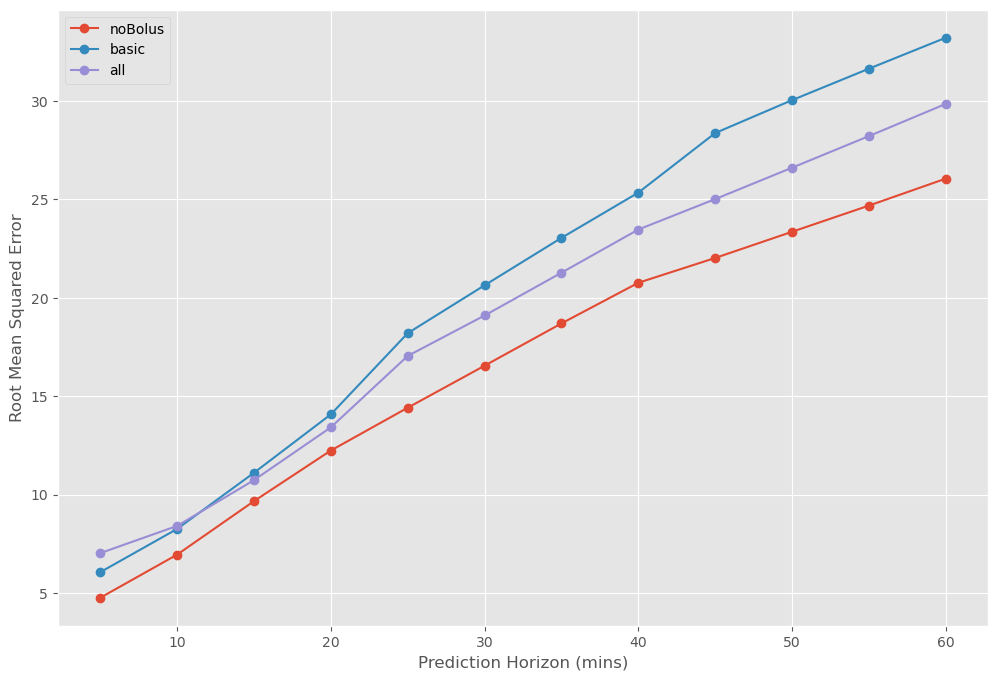

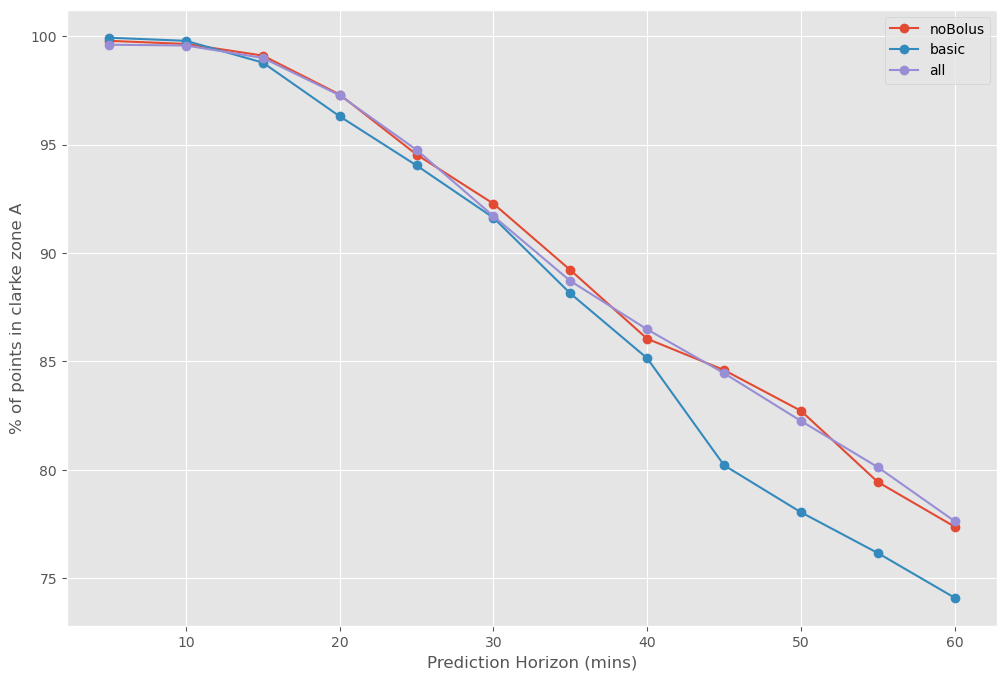

In [96]:
plot_index = patient_indices['588']
plot_ph_degrade_normed(['noBolus', 'basic', 'all'], '588', [scalers[plot_index],None,None], [True, False, False],
               [no_bolus(all_train_normed[plot_index]), glucose_input_only(all_train_data[plot_index]), all_train_data[plot_index]],
               [no_bolus(all_test_normed[plot_index]), glucose_input_only(all_test_data[plot_index]), all_test_data[plot_index]])

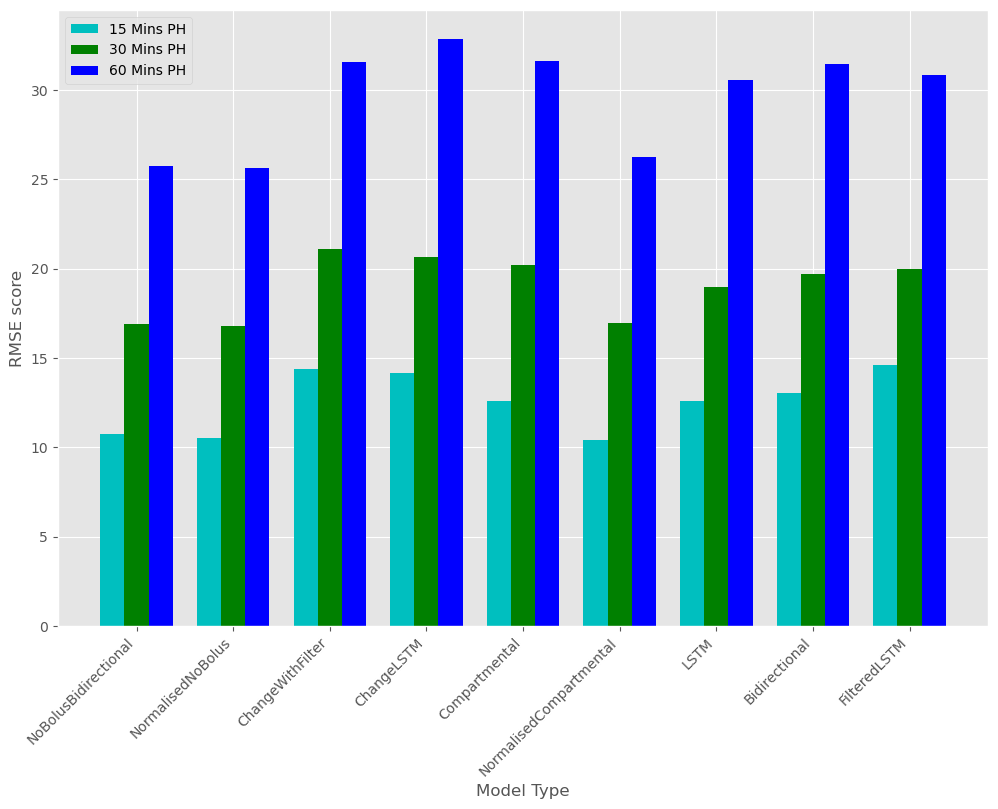

In [103]:
plot_accuracies('563')

## Clarke Error Grid Code

In [50]:
def clarke_error_zones(label, pred):
    """
    Clarke error grid zones
    """
    # Zone A
    if (label < 70 and pred < 70) or abs(label - pred) < 0.2 * label:
        return 0
    # Zone E - left upper
    if label <= 70 and pred >= 180:
        return 4
    # Zone E - right lower
    if label >= 180 and pred <= 70:
        return 4
    # Zone D - right
    if label >= 240 and 70 <= pred <= 180:
        return 3
    # Zone D - left
    if label <= 70 <= pred <= 180:
        return 3
    # Zone C - upper
    if 70 <= label <= 290 and pred >= label + 110:
        return 2
    # Zone C - lower
    if 130 <= label <= 180 and pred <= (7/5) * label - 182:
        return 2
    # Zone B - upper
    if label < pred:
        return 1
    # Zone B - lower
    return 1

clarke_error_zones = np.vectorize(clarke_error_zones)

In [51]:
def calculate_clarke_accuracies(model, pred_range, normalised=False, scaler=None):
    all_inputs, all_labels = get_all_test_inputs_and_labels(pred_range)
    predictions = model(all_inputs)[:,0,tf.newaxis]
    predictions = predictions.numpy().reshape(-1)
    all_labels = all_labels.reshape(-1)
    if normalised:
        predictions = inverse_glucose(scaler, predictions)
        all_labels = inverse_glucose(scaler, all_labels)
    accuracies = np.zeros(5)
    results = clarke_error_zones(all_labels, predictions)
    counts = np.bincount(results)
    accuracies[:len(counts)] = counts
    return accuracies / sum(accuracies)
    

In [52]:
# def create_range(shift, train, test, prev=PREV):

In [87]:
lstm = load_model('570', 'change30')
index = patient_indices['570']

In [88]:
range1 = create_range(6,
                     glucose_input_only(all_train_data[index]),
                     glucose_input_only(all_test_data[index]))

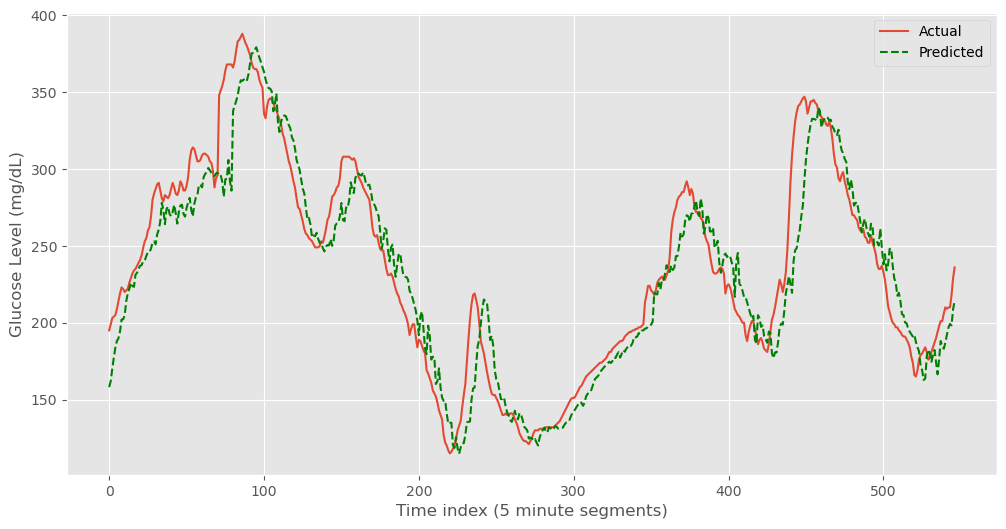

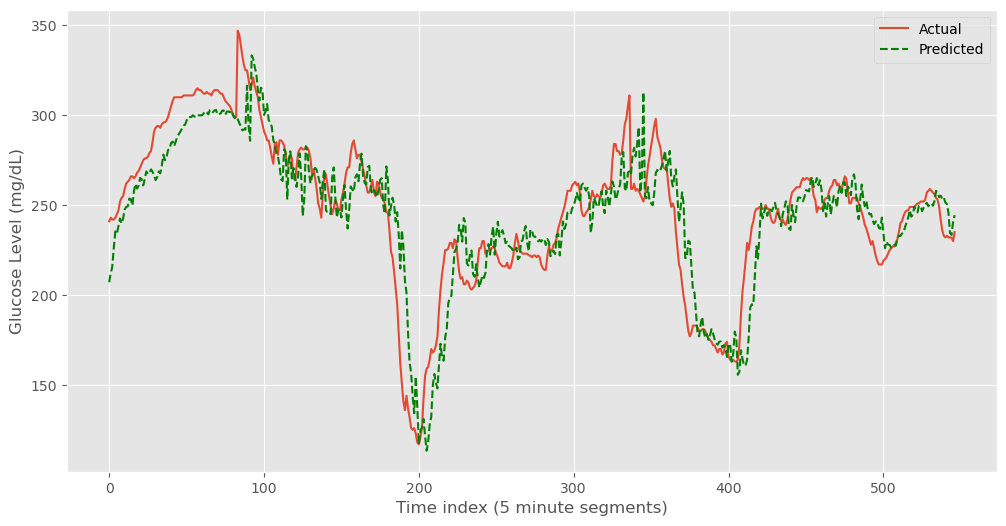

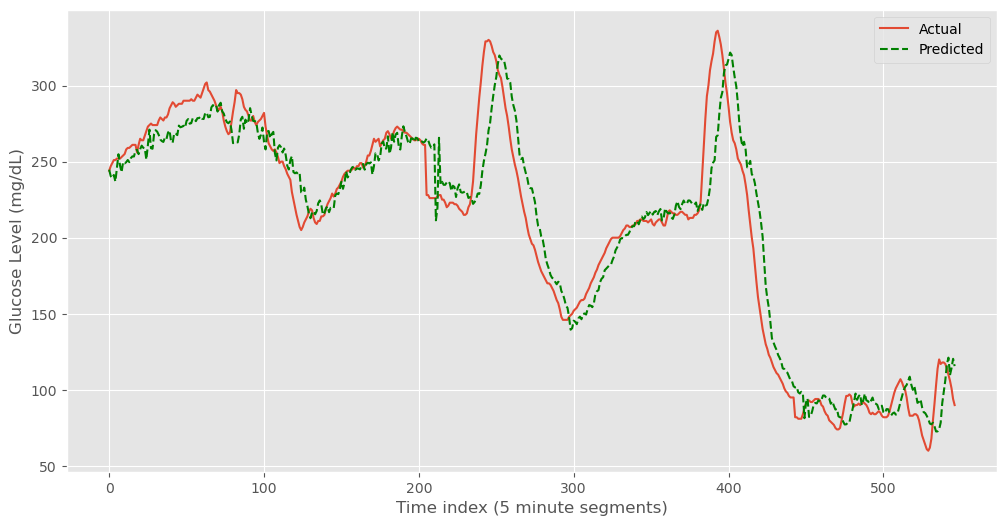

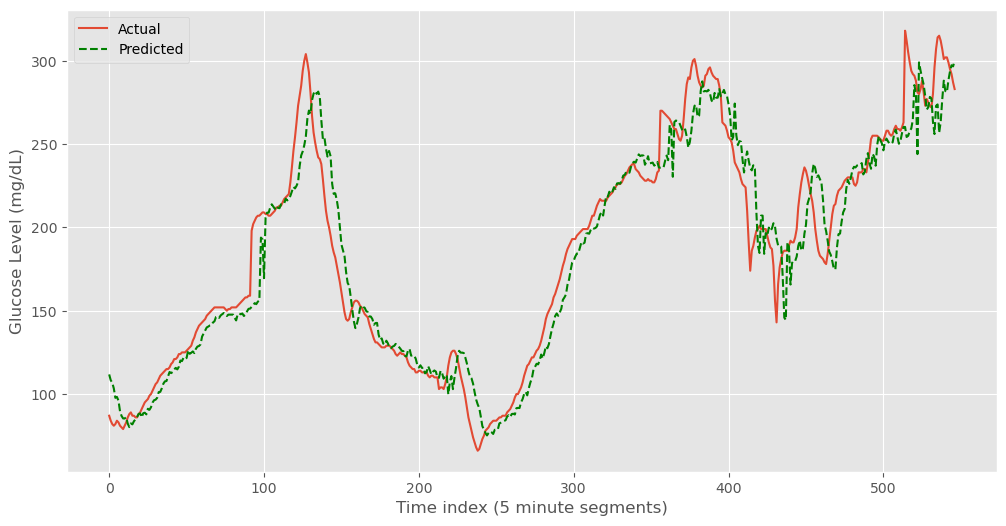

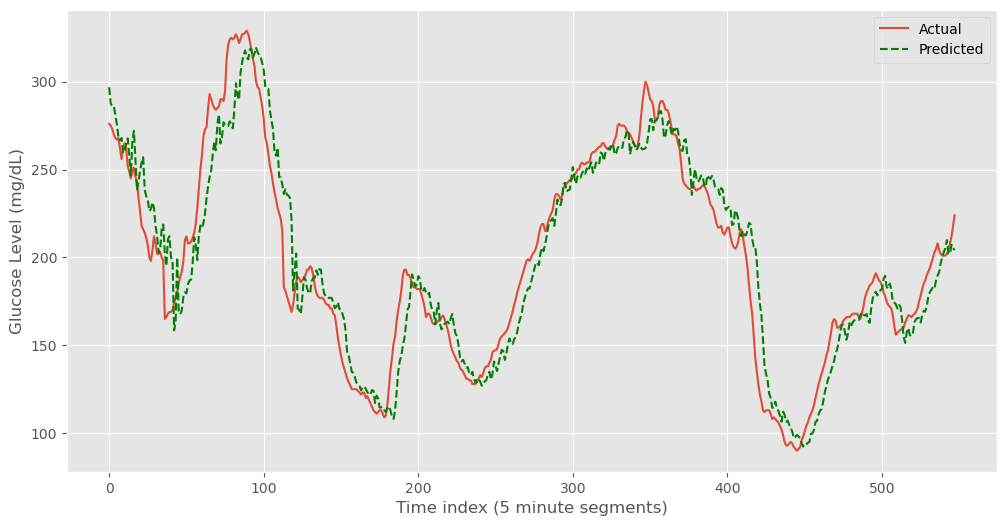

In [89]:
plot_model_predictions(lstm, range1,
                      num_graphs=5)

In [85]:
lstm2 = load_normed_model('570', 'noBolus30', scalers[index])

In [92]:
lstm3 = load_normed_model('570', 'noBolus15', scalers[index])

In [93]:
cur_range = create_range(3,
                         no_bolus(all_train_normed[index]),
                         no_bolus(all_test_normed[index]))

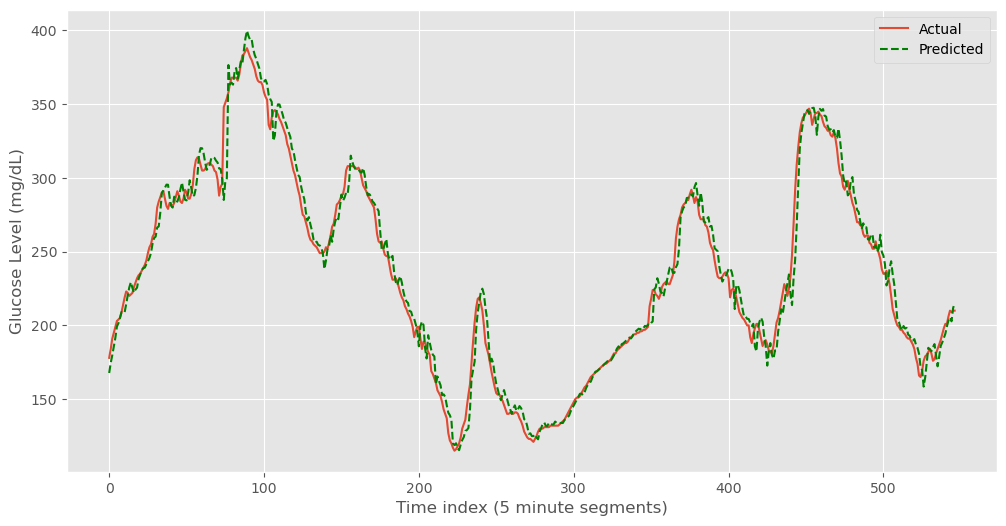

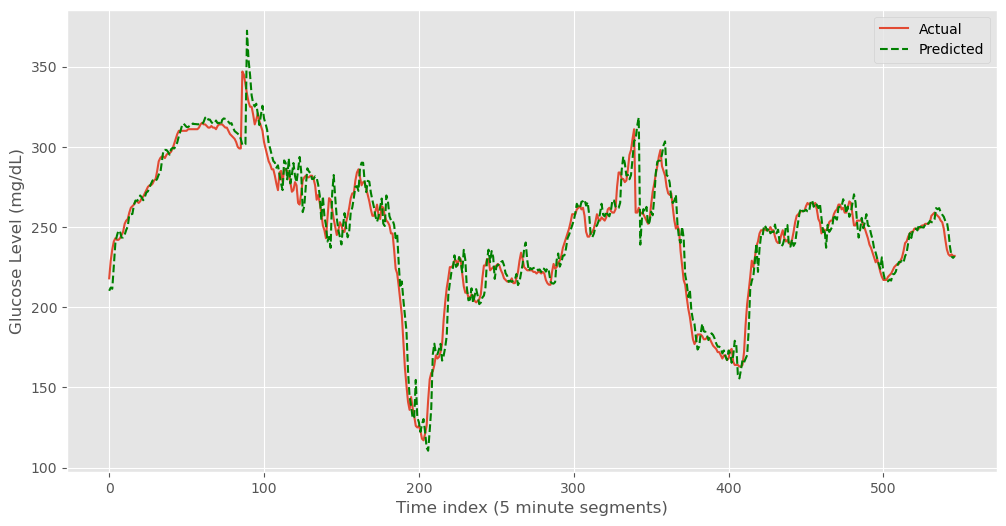

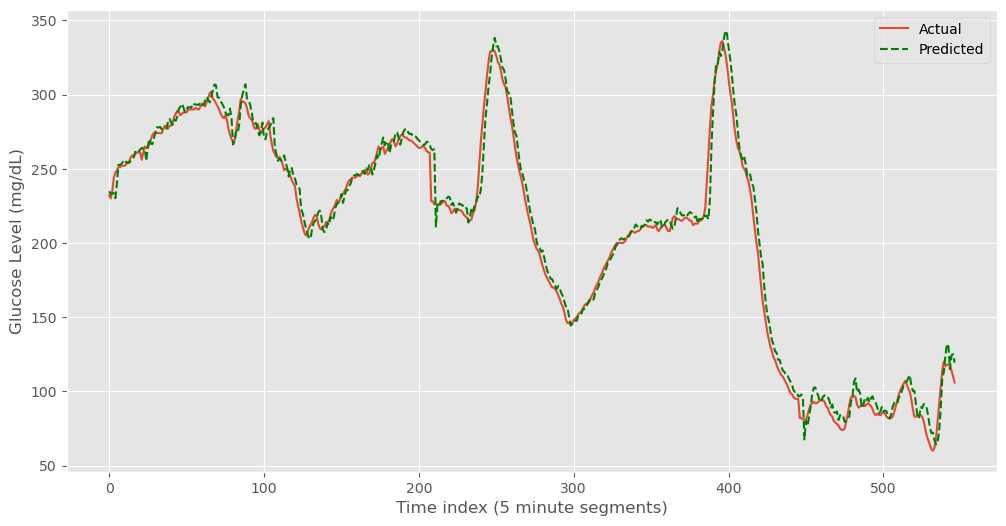

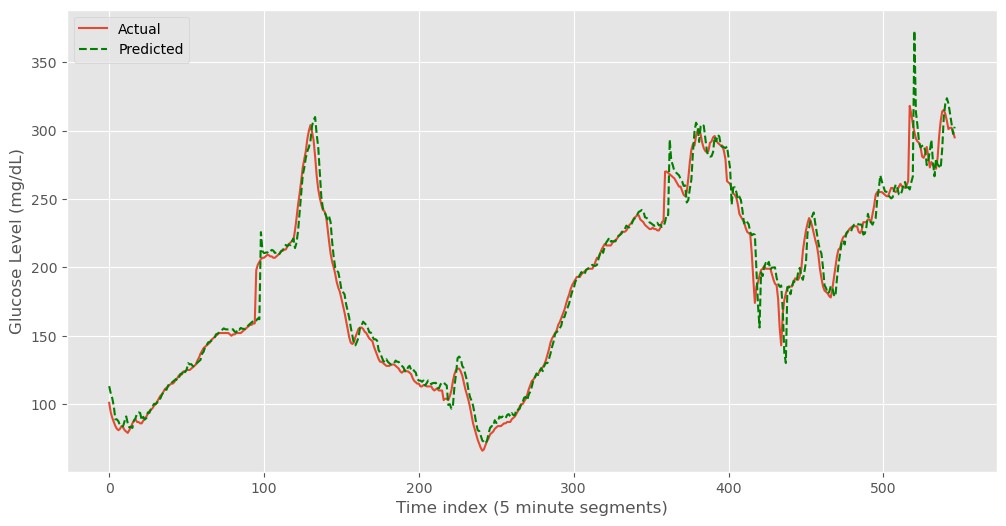

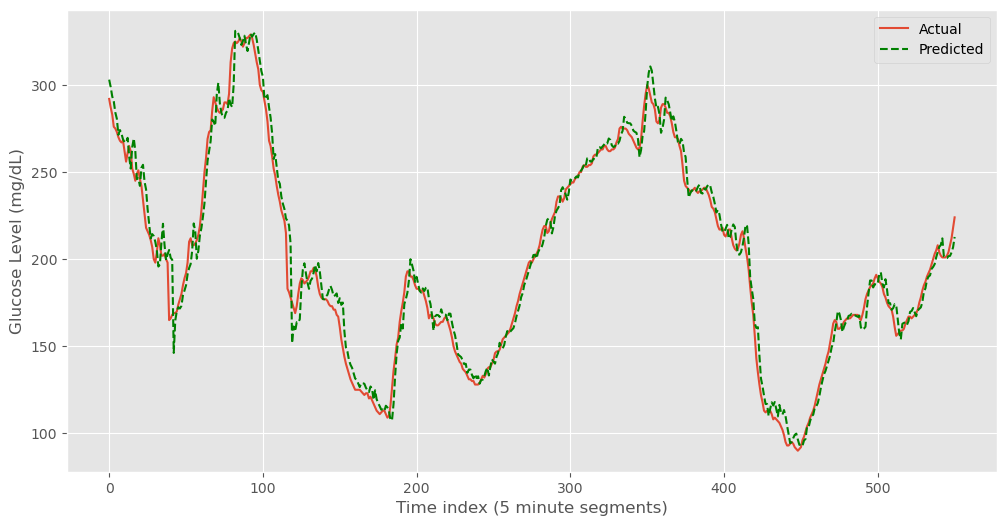

In [95]:
plot_model_predictions(lstm3, cur_range,
                      num_graphs=5,
                      normalised=True,
                      scaler = scalers[index])

In [65]:
calculate_clarke_accuracies(lstm2, cur_range, normalised=True, scaler=scalers[index])

array([0.94042398, 0.05592105, 0.        , 0.00365497, 0.        ])

In [66]:
lstm2.evaluate(cur_range.test)

86/86 [==============================] - 1s 4ms/step - loss: 0.0038 - RMSE: 18.4492


[0.0038246833719313145, 18.449155807495117]

In [67]:
lstm3.evaluate(cur_range.test)

86/86 [==============================] - 1s 4ms/step - loss: 0.0026 - RMSE: 15.3011


[0.0026350589469075203, 15.301126480102539]

In [110]:
linear_base.evaluate(range1.test)

86/86 [==============================] - 0s 748us/step - loss: 378.6477 - root_mean_squared_error: 19.4589


[378.6476745605469, 19.458871841430664]

In [109]:
lstm.evaluate(range1.test)

86/86 [==============================] - 0s 3ms/step - loss: 346.1896 - root_mean_squared_error: 18.6062 - mean_absolute_error: 13.3306


[346.18963623046875, 18.606172561645508, 13.33060359954834]

In [90]:
draw = load_model('570', 'bidirection30')

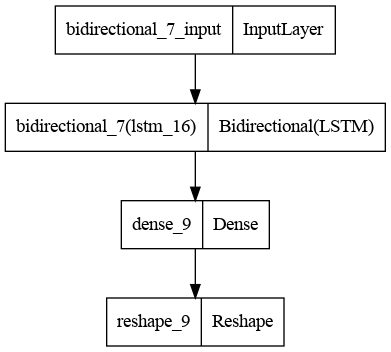

In [91]:
tf.keras.utils.plot_model(draw)